# Accounting for Spatial Autocorrelation in Regression Models

Tobler's First Law of Geography says *"Everything is related to everything else.  But near things are more related than distant things."*  

An important assumption when performing traditional regressions is that observations are independent.  The fact that observation A is high does not affect the probability that observation B is also high.  

Tobler's First Law means that for spatial datasets, that assumption basically never holds.  If observation A is close to observation B, they will likely have similar values (i.e. they are **spatially autocorrelated**).  If our observations are no longer independent, we can't rely on the results of an ordinary regression.

This notebook provides you with some tools to account for spatial autocorrelation, specifically a **spatial lag model** and a **spatial error model**.

## Part 1: Learning concepts with a toy dataset

### Step 1: Load the necessary libraries

When you run the cell below, you may get a warning regarding the specific version of R the libraries were built under.  You can ignore this warning.

In [1]:
library(spdep)
library(spatialreg)
library(GISTools)
library(rgdal)
library(RColorBrewer)

Warning message:
"package 'spdep' was built under R version 3.6.2"
Loading required package: sp

Loading required package: spData

Warning message:
"package 'spData' was built under R version 3.6.2"
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sf

Warning message:
"package 'sf' was built under R version 3.6.2"
Linking to GEOS 3.6.1, GDAL 2.2.3, PROJ 4.9.3

Warning message:
"package 'spatialreg' was built under R version 3.6.2"
Loading required package: Matrix

Registered S3 methods overwritten by 'spatialreg':
  method                   from 
  residuals.stsls          spdep
  deviance.stsls           spdep
  coef.stsls               spdep
  print.stsls              spdep
  summary.stsls            spdep
  print.summary.stsls      spdep
  residuals.gmsar          spdep
  deviance.gmsar           spdep
  coef.gmsar               spdep
 

### Step 2: Load the data

Spatial datasets that you want to use in R are most conveniently stored in a data format called a **shapefile** (which is actually a collection of several files).

To be able to use them in R, however, you will need to load them into a **spatial data frame**.  The code below will load the file and print out a summary of a toy dataset designed to illustrate the problems of spatial autocorrelation.

The important fields in this data set are CRIME, which is a measure of the crime rate in each region, and MINPOP, which is a measure of the population of color in each region.

In [2]:
sdf <-readOGR("examples.shp")
summary(sdf)

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\orms0027\Documents\day_of_data\examples.shp", layer: "examples"
with 84 features
It has 4 fields


Object of class SpatialPolygonsDataFrame
Coordinates:
       min      max
x 175837.0 215596.1
y 579810.7 607728.8
Is projected: TRUE 
proj4string :
[+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0
+datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0]
Data attributes:
       Id           GRID_ID       CRIME            MINPOP      
 Min.   : 0.00   A-1    : 1   Min.   :  1.00   Min.   :  1.00  
 1st Qu.: 0.00   A-2    : 1   1st Qu.:  1.00   1st Qu.:  1.00  
 Median : 6.50   A-3    : 1   Median :  1.00   Median :  1.00  
 Mean   :14.24   A-4    : 1   Mean   : 12.01   Mean   : 12.01  
 3rd Qu.:29.25   A-5    : 1   3rd Qu.: 13.50   3rd Qu.: 13.50  
 Max.   :48.00   A-6    : 1   Max.   :101.00   Max.   :101.00  
                 (Other):78                                    

### Step 3: Visualize the data

tmap is a good library to visualize spatial data in R, but sometimes it doesn't work.  Below is a function that will create a choropleth map from a spatial data frame using the GISTools library instead.  

You can read more about creating these types of maps in GISTools at https://www.rdocumentation.org/packages/GISTools/versions/0.7-4/topics/choropleth

In [3]:
choropleth_map <- function(dataframe, var,title,classes,cutter=sdCuts, ramp="RdPu") {
    variable <- as.numeric(var)
    variable.shade <- auto.shading(variable,cutter=cutter,n=classes,cols=brewer.pal(classes,ramp))
    choropleth(dataframe,variable,shading=variable.shade)
    title(title, cex.main=2)  
}

If we want to visualize the variables, we need to pass correct parameters to the function we defined above.  Let's start with the MINPOP variable

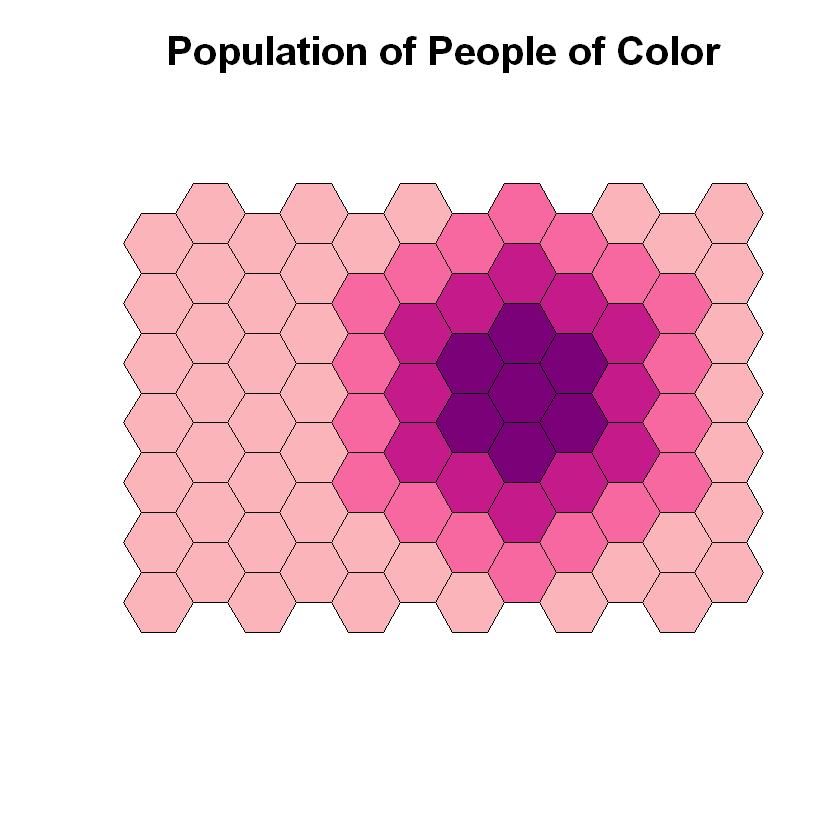

In [4]:
dataframe = sdf # which dataframe to use
var = sdf$MINPOP # which variable will be mapped
title = "Population of People of Color" # the title to print at the top of the figure
classes = 5 # the number of groups to break the data into
ramp = "RdPu" # the color ramp to use.  Since values go from high to low, a ramp that goes from light to dark is appropriate

choropleth_map (dataframe,var,title, classes, ramp=ramp)

Next we can map the CRIME variable.  **Try to create the code yourself in the cell below, using the examples above.  If you have trouble, [check here](https://github.com/travisormsby/day_of_data) for the answer:**

### Step 4: Create a non-spatial regression model

Visually, we can see that the two variables have quite a bit of overlap, which makes us think they might be correlated.  The code below will create an ordinary least squares (OLS) regression model with MINPOP as the explanatory variable and CRIME as the response variable.

In [5]:
# create the regression model
ols <- lm(CRIME ~ MINPOP, data = sdf)

#print the summary
summary(ols)

#plot the relationship
plot(sdf$MINPOP, shp$CRIME)
abline(ols)


Call:
lm(formula = CRIME ~ MINPOP, data = sdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.303  -6.026  -6.026   6.474  82.655 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.57329    2.07338   3.170  0.00214 ** 
MINPOP       0.45277    0.09846   4.598 1.53e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 15.61 on 82 degrees of freedom
Multiple R-squared:  0.205,	Adjusted R-squared:  0.1953 
F-statistic: 21.14 on 1 and 82 DF,  p-value: 1.53e-05


ERROR: Error in plot(sdf$MINPOP, shp$CRIME): object 'shp' not found


Based on these results, how would you interpret the relationship between these two variables?

### Step 5: Think spatially

Just looking at the results above, you might rush to publish your analysis without thinking about the effects of spatial autocorrelation.

But since you were smart enough to attend this session, you know better than that.  

What if we mapped the residuals from the OLS model?  If the model was appropriate, then you wouldn't be able to use a region's location to predict the value of the residual (i.e. the residuals would be spatially random).

The code below will use our mapping function to map the residuals

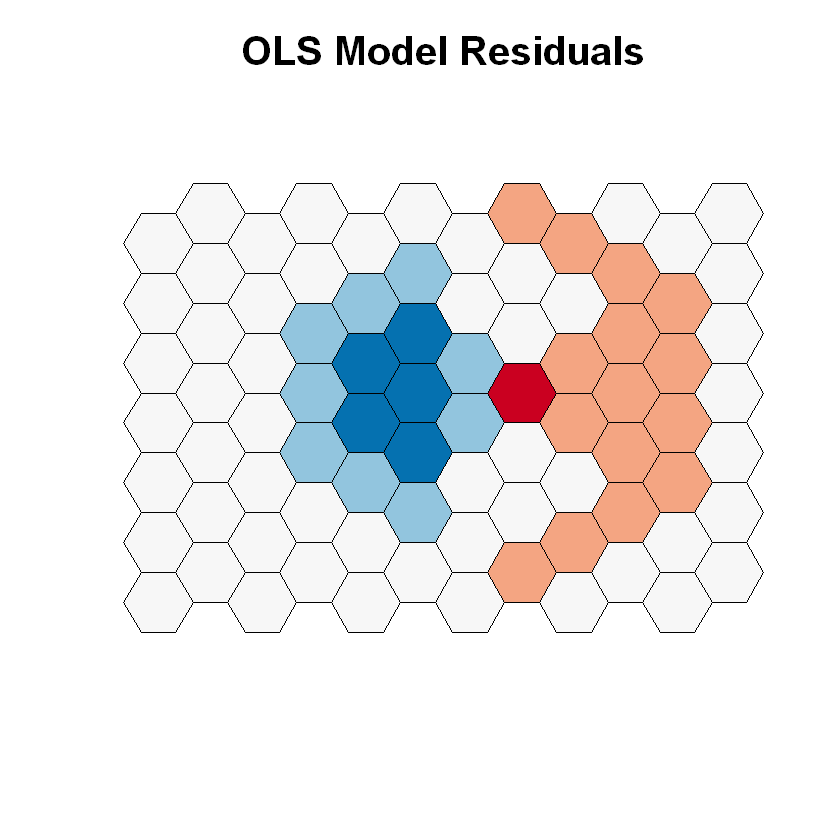

In [6]:
# map the ols model residuals
dataframe = sdf
var = resid(ols)
title = "OLS Model Residuals"
classes = 5
ramp = "RdBu" # since residuals are both positive and negative, a diverging color ramp like Red-Blue is appropriate


choropleth_map (dataframe,var,title, classes, ramp=ramp)

Does that look spatially random to you?

We don't always have such obvious datasets, and we need a way to test the degree of spatial autocorrelation.  **Moran's I** is a statistic that measures spatial autocorrelation.  Its value can range from -1 to 1.  A value of 0 indicates no autocorrelation.  A positive value indicates that Tobler's law holds true: close things are more similar than distant things.  A negative value indicates the opposite: close things are more dissimilar than distant things (this is pretty rare in real life).

To calculate Moran's I, the first thing we need to do is figure out what it means for things to be "close".  We'll use the definition that two regions are "close" if they share an edge and "far" if they don't.

The code below will convert the region polygons into a contiguity graph where each region is a node and each edge connects a region to the other regions it shares an edge with.

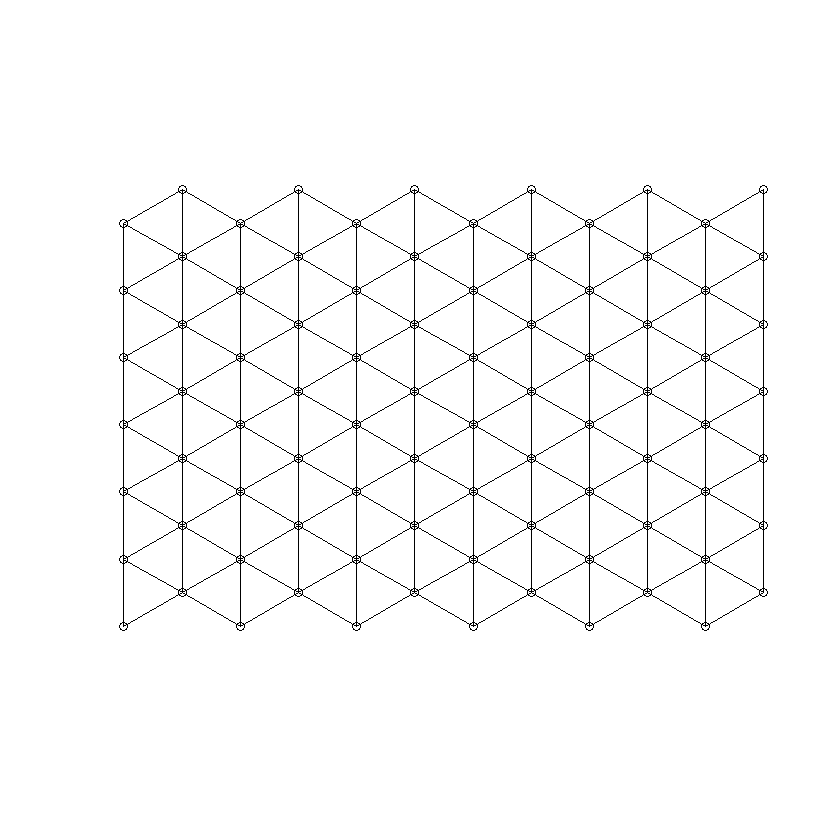

In [7]:
# create a contiguity graph
sdf.nb <- poly2nb(sdf)

# visualize the contiguity graph
plot(sdf.nb, coordinates(sdf))

We can use that contiguity graph to create what's called a row-standardized spatial weights matrix.  This matrix is needed to calculate Moran's I.

We're not going to go into all the math behind what this matrix is, but you can read more about it here: https://geodacenter.github.io/workbook/4a_contig_weights/lab4a.html

In [8]:
# create a row-standardized neighborhood weights matrix W
W <- nb2listw(sdf.nb)

Once we have the weights matrix, we can measure the autocorrelation in the residuals.  Given the map we saw above, we should expect this number to be positive and closer to 1 than 0.

The code below will calculate Moran's I

In [9]:
# add the residuals as a field to the spatial data frame
sdf$ols.res <- resid(ols) 

# calculate Moran's I of the residuals, using the spatial weights matrix W
moran.test(sdf$ols.res,W)


	Moran I test under randomisation

data:  sdf$ols.res  
weights: W    

Moran I statistic standard deviate = 10.799, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.678932730      -0.012048193       0.004094336 


### Step 6: Correct for autocorrelation

The high and statistically significant Moran's I value confirms what we saw in the map of the residuals: they are spatially autocorrelated and therefore the non-spatial OLS model doesn't tell us the right story about the relationship between the variables.  But Moran's I doesn't tell us what we should do about it.

Primarily, we need to decide whether to use a spatial lag model or a spatial error model to create a better specified model.  

A **spatial lag model** treats the spatial autocorrelation as the result of some kind of diffusion in your response variable.  Pollution is a good example of autocorrelation due to spatial lag.  Areas close to a pollution source have higher pollution values because the pollution spread to them from the source.

A **spatial error model** treats the spatial autocorrelation as the result of some autocorrelated variable that isn't being accounted for in the model.  Maybe you don't know what it is, or maybe you can't measure it, but for whatever reason, you can't account for it in the model.  The spatial error model can control for this missing variable.

Ideally, your choice of a spatial lag or spatial error model should be driven by your subject matter expertise and understanding of the underlying phenomenon.  If spatial autocorrelation in your response variable can plausibly be said to be due to diffusion, you should use a lag model.  Use an error model otherwise.

But sometimes you don't really know.  Fortunately, we can turn to a statistical test called the Lagrage Multiplier to help us pick.  The code below will run the test on the OLS model we created earlier and print out the results.

In [10]:
LM <- lm.LMtests(ols, W, test="all")
summary(LM)

	Lagrange multiplier diagnostics for spatial dependence
data:  
model: lm(formula = CRIME ~ MINPOP, data = sdf)
weights: W
 
       statistic parameter p.value    
LMerr  94.183226         1 < 2e-16 ***
LMlag  99.479206         1 < 2e-16 ***
RLMerr  0.061337         1 0.80439    
RLMlag  5.357317         1 0.02064 *  
SARMA  99.540543         2 < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

So, yeah, that's a lot of numbers.  What do they mean?

First we're looking at the **LMerr** and **LMlag** values.  If the LMerr value is a lot higher, than a spatial error model will probably create a better model fit.  If the LMlag value is a lot higher, than a spatial lag model will probably be better.

Lots of times, however, you get the same thing as this dataset: both values are pretty close together.  There is a "robust" version of each test that is intended to help.  Compare the **RLMerr** value to the **RLMlag** value.  Whichever one is higher and statistically significant will create a better model fit.  If the robust values are also similar, probably both spatial lag and spatial error are having an effect, and there is no good way to account for both of them at once.  In this case, however, the robust test suggests that a spatial lag model is more appropriate than spatial error.  

Again, this is a good time to remind you that using the Lagrange Multiplier test is a second-best option.  It won't be good as actually understanding the phenomenon.

The code below will create a spatial lag model using the spatial weights matrix W

In [11]:
lag <- lagsarlm(CRIME ~ MINPOP, data = sdf, W)
summary(lag)


Call:lagsarlm(formula = CRIME ~ MINPOP, data = sdf, listw = W)

Residuals:
     Min       1Q   Median       3Q      Max 
-9.34832 -2.91608  0.49348  0.64815 51.18850 

Type: lag 
Coefficients: (asymptotic standard errors) 
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.515178   0.874799 -0.5889  0.55592
MINPOP       0.071187   0.041967  1.6963  0.08984

Rho: 0.95051, LR test value: 115.53, p-value: < 2.22e-16
Asymptotic standard error: 0.025217
    z-value: 37.693, p-value: < 2.22e-16
Wald statistic: 1420.8, p-value: < 2.22e-16

Log likelihood: -291.229 for lag model
ML residual variance (sigma squared): 42.509, (sigma: 6.5199)
Number of observations: 84 
Number of parameters estimated: 4 
AIC: 590.46, (AIC for lm: 703.98)
LM test for residual autocorrelation
test value: 9.2198, p-value: 0.0023941


There are four important values to pay attention to in the output:

* **variable estimate** - this indicates whether the relationship is positively or negatively correlated
* **Pr(>|z|)** - this indicates the probability that the relationship is real (as opposed to due to random chance)
* **AIC** - this is a measure of the spatial model fit.  For our purposes, you can compare AIC for models that have the same response variable values.  Lower AIC indicates better fit, as long as the difference is more than about 2 or 3.
* **AIC** for lm - this is a measure of the non-spatial model fit.

In this case, we find that the relationship in the spatial regression model is still positive, just like it was in the OLS model.  The probability that this relationship is due to random chance, however, is much higher than it was in the OLS model.  This value is now to high to plausibly reject the idea that crime rates are uncorrelated with populations of color.

Comparing AIC values for the two models, we find that the spatial lag model is a much better fit than the non-spatial OLS model.

To convince ourselves that we have improved the model, try mapping the residuals from the lag model and calculating Moran's I.  If it really worked, the residuals should look more randomly distributed and Moran's I should be a lot closer to 0.

**Try to create the code yourself in the cell below, using the examples above.  If you have trouble, [check here](https://github.com/travisormsby/day_of_data) for the answer:**

### Step 7: Create a Spatial Error Model just for fun

Since a lag model won't always be best, you're going to want to know how to actually create spatial error models.  The code below will create one.

In [12]:
sem <- errorsarlm(CRIME~MINPOP,data = sdf, W)
summary(sem)


Call:errorsarlm(formula = CRIME ~ MINPOP, data = sdf, listw = W)

Residuals:
     Min       1Q   Median       3Q      Max 
-8.43882 -3.11603 -0.13416  0.40638 51.53821 

Type: error 
Coefficients: (asymptotic standard errors) 
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  4.809100  20.085125  0.2394   0.8108
MINPOP      -0.033273   0.107972 -0.3082   0.7580

Lambda: 0.96447, LR test value: 112.84, p-value: < 2.22e-16
Asymptotic standard error: 0.019911
    z-value: 48.438, p-value: < 2.22e-16
Wald statistic: 2346.2, p-value: < 2.22e-16

Log likelihood: -292.5695 for error model
ML residual variance (sigma squared): 42.774, (sigma: 6.5402)
Number of observations: 84 
Number of parameters estimated: 4 
AIC: 593.14, (AIC for lm: 703.98)


We're interested in the same values as we got from the spatial lag model output.  Some differences you should notice is that the sign on the correlation coefficient is now negative, but is even more likely to be due to chance.  The AIC is lower than the non-spatial model, but higher than the spatial lag model, which is further confirmation that the lag model provides the better fit.

Mapping and calculating Moran's I for the residuals is left to the interested reader

### Step 8: So What?

The OLS model is simply wrong.  And if we hadn't bee thinking spatially, we might have published those wrong results.  The potential harm from publishing bad research extends far beyond whatever embarrasment we might feel from having somebody else prove us wrong later.  That publication could have had serious consequences for policing, legislation, and society.

# Part 2: Correct for spatial autocorrelation in a real dataset

A toy dataset like we used above is fine for demonstrating a concept.  But we want to apply these techniques to a real dataset.

### Beginner:

Run through the steps below

### Intermediate:

Run through the steps below a few times, testing different linear models each time

### Expert:

Run through the steps below using your own spatial data.  You may need to load them into a spatial dataframe differently if they are not already in shapefile format.

### Step 2: Load the census data

In [13]:
ct.sdf <- readOGR("censustract.shp")
summary(ct.sdf)

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\orms0027\Documents\day_of_data\censustract.shp", layer: "censustract"
with 732 features
It has 7 fields
Integer64 fields read as strings:  Sum_TOTPOP Sum_MINORI 


Object of class SpatialPolygonsDataFrame
Coordinates:
        min       max
x -94.01253 -92.73189
y  44.47115  45.41478
Is projected: FALSE 
proj4string :
[+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0]
Data attributes:
   Sum_TOTPOP    Sum_MINORI    Avg_MEDHIN       Sum_BA_HIG      Avg_Avg_NO    
 2997   :  4   132    :  4   Min.   : 18718   Min.   :  118   Min.   : 2.935  
 15212  :  3   1356   :  3   1st Qu.: 54536   1st Qu.: 2377   1st Qu.: 6.939  
 11260  :  2   2425   :  3   Median : 70152   Median : 3777   Median : 9.600  
 12237  :  2   3813   :  3   Mean   : 71116   Mean   : 4316   Mean   : 9.484  
 12330  :  2   1159   :  2   3rd Qu.: 87555   3rd Qu.: 5791   3rd Qu.:11.877  
 12386  :  2   1371   :  2   Max.   :138578   Max.   :19022   Max.   :18.964  
 (Other):717   (Other):715                                                    
      Pedu            Pminori      
 Min.   :0.05437   Min.   :0.0339  
 1st Qu.:0.19143   1st Qu.:0.1400  
 Median :0.26987   Med

### Step 3: Visualize the data

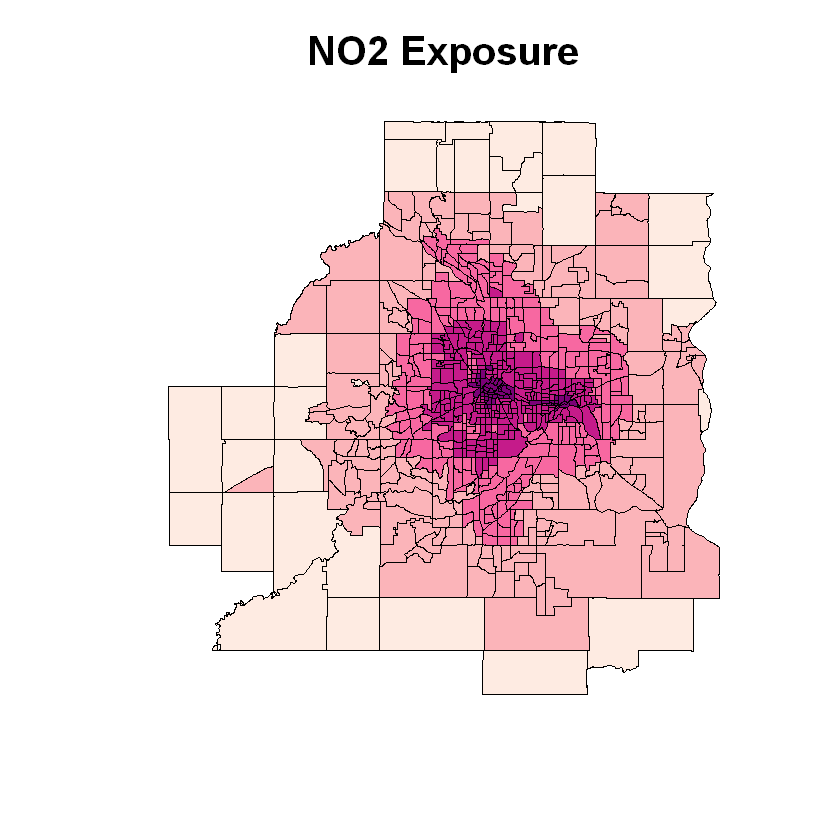

In [14]:
# create a map of NO2 Exposure
dataframe = ct.sdf
var = ct.sdf$Avg_Avg_NO
title = "NO2 Exposure"
classes = 5
ramp = "RdPu"

choropleth_map(dataframe,var,title, classes, ramp=ramp)

In [ ]:
# create a map of any other variable in the dataset
dataframe = ct.sdf
var = 
title = 
classes =
ramp =

choropleth_map(dataframe,var,title, classes, ramp=ramp)

### Step 4: Create a Non-spatial regression model

In [ ]:
# create the regression model.  


# print the summary


# plot the relationship



### Step 5: Think Spatially

In [151]:
# map the residuals


# create a contiguity graph


# visualize the contiguity graph


# create a row-standardized neighborhood weights matrix W


# add the residuals from the OLS model as a field to the spatial data frame
 

# calculate Moran's I of the OLS residuals, using the spatial weights matrix W



How did your non-spatial model do?  Do you need to correct for spatial autocorrelation?  

If not, you're done - go back and see if you can find a linear model that does need correction.

If you do need to correct for autocorrelation, keep going.

### Step 6: Correct for spatial autocorrelation

Are you enough of a subject matter expert on these data to make an argument about whether a spatial lag model or a spatial error model is more appropriate?  If so, skip the Lagrange Multiplier test.  If not, run the test to see which one will provide a better model fit

Create your spatial lag or spatial error model in the cell below

What, if anything, changed between the OLS and the spatial regression model?  Did the AIC of the spatial model indicate improved model fit?